# Stellargraph example: directed CORA citation network with directed GraphSAGE and Neo4J.

This example shows the application of *directed* GraphSAGE to a *directed* graph, where the in-node and out-node neighbourhoods are separately sampled and have different weights. Subgraphs are sampled directly from Neo4J, which eliminate the need to store the whole graph structure in NetworkX. Node features, however, still need to be loaded in memory.


In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import os

import stellargraph as sg
from stellargraph.connector.neo4j import Neo4JDirectedGraphSAGENodeGenerator
from stellargraph.layer import DirectedGraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import py2neo
import time

### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz).

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Getting the node data from neo4j.

In [2]:
neo4j_graphdb = py2neo.Graph("http://localhost:7474", auth=("neo4j", "cora"))

def get_node_data_from_neo4j(neo4j_graphdb):

    fetch_node_query = "MATCH (node) RETURN id(node), properties(node)"

    # run the node-fetching query
    node_records = neo4j_graphdb.run(fetch_node_query)

    # convert the node records into pandas dataframe
    return pd.DataFrame(node_records).rename(columns={0: "id", 1: "attr"})


start = time.time()
node_data = get_node_data_from_neo4j(
    neo4j_graphdb
)
end = time.time()

print(f"{end - start:.2f} s: Loaded node data from neo4j database to memory")

5.84 s: Loaded node data from neo4j database to memory


Extract the node features which will be consumed by GraphSAGE

In [3]:
node_data = node_data.set_index("id")
attribute_df = node_data["attr"].apply(pd.Series)

node_data = attribute_df.drop(labels=["ID"], axis=1)

node_features = pd.DataFrame(node_data["features"].values.tolist(), index=node_data.index)
node_data

,features,subject
id,,
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Neural_Networks
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Probabilistic_Methods
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Neural_Networks
3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Neural_Networks
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Theory
...,...,...
6024,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Neural_Networks
6025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Probabilistic_Methods
6026,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Neural_Networks


At this point, although we do not store all edges, it is still necessary to put all nodes in NetworkX object.

In [4]:
Gnx = nx.DiGraph()
Gnx.add_nodes_from(node_data.index, label="paper")

In [5]:
labels = np.array(node_data["subject"])

target_encoding = preprocessing.OneHotEncoder(sparse=False, categories="auto")
targets = target_encoding.fit_transform(labels.reshape(-1, 1))
targets = pd.DataFrame(targets, index=node_data.index)

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [6]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this

In [7]:
train_data, test_data = model_selection.train_test_split(
    node_data, train_size=0.1, test_size=None, stratify=node_data["subject"]
)

Note using stratified sampling gives the following counts:

In [8]:
from collections import Counter

Counter(train_data["subject"])

Counter({'Theory': 35,
         'Genetic_Algorithms': 42,
         'Probabilistic_Methods': 42,
         'Case_Based': 30,
         'Neural_Networks': 81,
         'Rule_Learning': 18,
         'Reinforcement_Learning': 22})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [9]:
train_data[["subject"]]

,subject
id,
1761,Theory
885,Genetic_Algorithms
1546,Theory
108,Probabilistic_Methods
1414,Probabilistic_Methods
...,...
21,Reinforcement_Learning
1412,Neural_Networks
642,Neural_Networks


In [10]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict("records"))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict("records"))


print(train_targets)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

## Creating the GraphSAGE model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

Since the subgraph is sampled directly from Neo4J, we only need to retain the node data features and do not need to store all edges in the NetworkX object.  

Note that the NetworkX graph is *directed*, so we also treat it here as *directed*.

In [11]:
G = sg.StellarDiGraph(Gnx, node_features=node_features)

In [12]:
print(G.info())

NetworkXStellarGraph: Directed multigraph
 Nodes: 2708, Edges: 0

 Node types:
  paper: [2708]
    Edge types: 

 Edge types:



To feed data from the graph to the Keras model we need a data generator that feeds data from the graph to the model. The generators are specialized to the model and the learning task so we choose the `DirectedGraphSAGENodeGenerator` as we are predicting node attributes with a `DirectedGraphSAGE` model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer (5 in-nodes and 5 out-nodes), and 4 in the second layer (2 in-nodes and 2 out-nodes).

In [13]:
batch_size = 50
in_samples = [5, 2]
out_samples = [5, 2]

A `DirectedGraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [14]:
generator = Neo4JDirectedGraphSAGENodeGenerator(
    G, batch_size, in_samples, out_samples, neo4j_graphdb=neo4j_graphdb
)

/home/ho049/subsampling/stellargraph/stellargraph/core/experimental.py:88: ExperimentalWarning: Neo4JDirectedGraphSAGENodeGenerator is experimental: the class is not fully tested. It may be difficult to use and may have major changes at any time.
  warnings.warn(direct_msg, ExperimentalWarning)
/home/ho049/subsampling/stellargraph/stellargraph/core/experimental.py:88: ExperimentalWarning: Neo4JBatchedNodeGenerator is experimental: the class is not fully tested. It may be difficult to use and may have major changes at any time.
  warnings.warn(direct_msg, ExperimentalWarning)
/home/ho049/subsampling/stellargraph/stellargraph/core/experimental.py:88: ExperimentalWarning: Neo4JDirectedBreadthFirstNeighbors is experimental: the class is not fully tested. It may be difficult to use and may have major changes at any time.
  warnings.warn(direct_msg, ExperimentalWarning)


In [15]:
generator.sample_features([1,2])

[array([[[0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.]]]),
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]),
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]),
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., 

Using the `generator.flow()` method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [16]:
train_gen = generator.flow(train_data.index, train_targets, shuffle=True)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer, which corresponds to 12 weights for each head node, 10 for each in-node and 10 for each out-node.
 * The `bias` and `dropout` are internal parameters of the model. 

In [17]:
graphsage_model = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=False, dropout=0.5,
)

Now we create a model to predict the 7 categories using Keras softmax layers.

In [18]:
x_inp, x_out = graphsage_model.build()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [19]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [20]:
test_gen = generator.flow(test_data.index, test_targets)

In [21]:
history = model.fit_generator(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20
6/6 - 9s - loss: 1.8904 - acc: 0.2556 - val_loss: 1.7551 - val_acc: 0.4007
Epoch 2/20
6/6 - 6s - loss: 1.6906 - acc: 0.5111 - val_loss: 1.6403 - val_acc: 0.4594
Epoch 3/20
6/6 - 7s - loss: 1.5752 - acc: 0.5778 - val_loss: 1.5318 - val_acc: 0.5890
Epoch 4/20
6/6 - 6s - loss: 1.4388 - acc: 0.7074 - val_loss: 1.4351 - val_acc: 0.6801
Epoch 5/20
6/6 - 5s - loss: 1.3269 - acc: 0.8222 - val_loss: 1.3522 - val_acc: 0.7153
Epoch 6/20
6/6 - 6s - loss: 1.2218 - acc: 0.8519 - val_loss: 1.2690 - val_acc: 0.7281
Epoch 7/20
6/6 - 6s - loss: 1.1324 - acc: 0.8556 - val_loss: 1.1953 - val_acc: 0.7408
Epoch 8/20
6/6 - 6s - loss: 1.0067 - acc: 0.8852 - val_loss: 1.1352 - val_acc: 0.7473
Epoch 9/20
6/6 - 6s - loss: 0.9598 - acc: 0.8963 - val_loss: 1.0798 - val_acc: 0.7642
Epoch 10/20
6/6 - 5s - loss: 0.8892 - acc: 0.9148 - val_loss: 1.0431 - val_acc: 0.7625
Epoch 11/20
6/6 - 5s - loss: 0.8112 - acc: 0.9296 - val_loss: 0.9967 - val_acc: 0.7683
Epoch 12/20
6/6 - 5s - loss: 0.7507 - acc: 0.9407 - 

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()

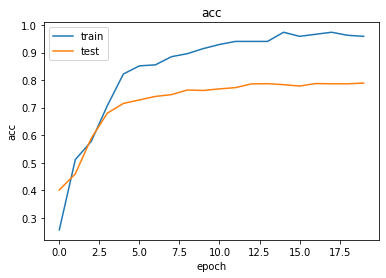

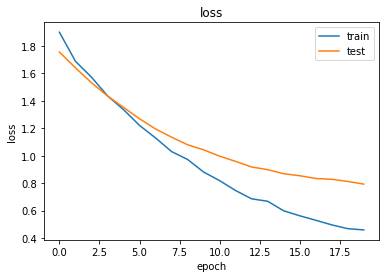

In [23]:
plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [24]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.7952
	acc: 0.7801


### Making predictions with the model

Now let's get the predictions themselves for all nodes using another node iterator:

In [25]:
all_nodes = node_data.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_mapper)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

In [26]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few:

In [27]:
results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data["subject"]})
df.head(10)

,Predicted,True
id,,
0,subject=Neural_Networks,Neural_Networks
1,subject=Probabilistic_Methods,Probabilistic_Methods
2,subject=Neural_Networks,Neural_Networks
3,subject=Neural_Networks,Neural_Networks
4,subject=Theory,Theory
5,subject=Neural_Networks,Neural_Networks
6,subject=Reinforcement_Learning,Reinforcement_Learning
7,subject=Genetic_Algorithms,Genetic_Algorithms
8,subject=Reinforcement_Learning,Theory


Please refer to [directed-graphsage-on-cora-example.ipynb](https://github.com/stellargraph/stellargraph/blob/develop/demos/node-classification/graphsage/directed-graphsage-on-cora-example.ipynb) for the **graphml visualisation**, and **node embeddings**.